# DFT/DCT using TenSEAL

Performing DFT/DCT on encrypted physical signal to find dominant frequencies.
Computation is done using standard (non-optimized) matrix vector multiplication.
To handle complex values in DFT, real and imaginary part is split in two matrices.

Finding dominant frequency:
Frequency with highest amplitude should be found.
To do that, approximate functions are used (HE-friendly) on unencrypted data.


In [1]:
from scipy import fft
import matplotlib.pyplot as plt
import math
import numpy as np
import tenseal as ts

In [2]:
# Import Hammer-Data
data_hydr = np.loadtxt("./sensitive_data/data.csv", skiprows=2, delimiter=",", usecols=[0, 1, 2, 3])

N = 500
sampling_T = 0.002
sampling_f = 1 / sampling_T

In [3]:
# scale data
data_raw = data_hydr[:N,1]

ymax = max(data_raw)
ymin = min(data_raw)
data_scaled = (data_raw - ymin) / (ymax - ymin)

input_data = data_scaled - np.average(data_scaled)

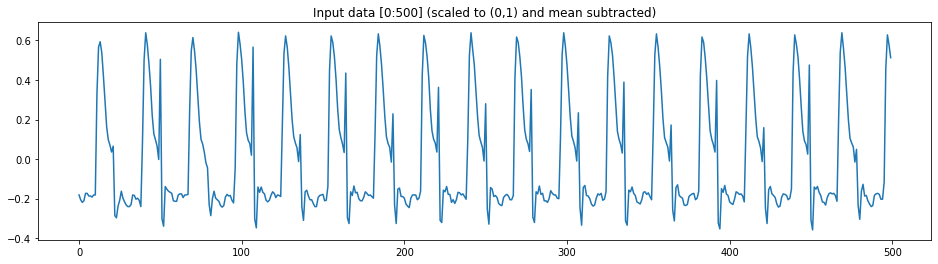

In [4]:
# plot data
plt.plot(input_data)
plt.gcf().set_size_inches(16, 4)
plt.title(f"Input data [0:{N}] (scaled to (0,1) and mean subtracted)")
plt.show()

In [5]:
# DFT and DCT

dft = np.fft.rfft(input_data)
dct = fft.dct(input_data, type=2)

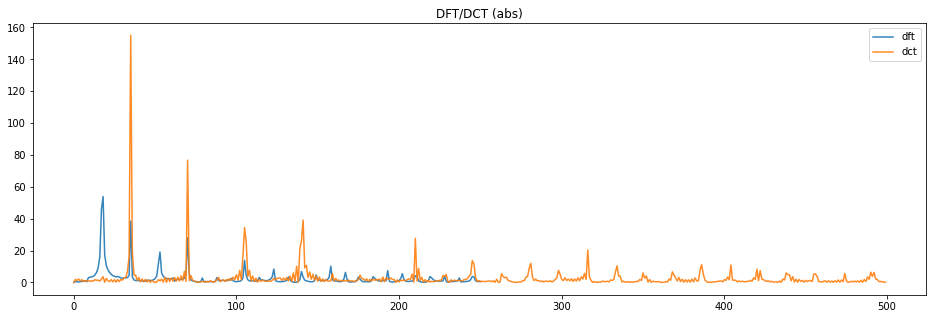

DFT max at 18
DCT max at 35
f = 18.0 Hz


In [6]:
plt.plot(np.abs(dft), alpha=0.9, label="dft")
plt.plot(np.abs(dct), alpha=0.9, label="dct")
plt.legend()
plt.gcf().set_size_inches(16, 5)
plt.title("DFT/DCT (abs)")
plt.show()

dftmax = np.argmax(np.abs(dft))
print(f"DFT max at {dftmax}")
dctmax = np.argmax(np.abs(dct))
print(f"DCT max at {dctmax}")

df = sampling_f / N
print(f"f = {df*dftmax} Hz")

In [7]:
# TenSEAL Context
bits_scale = 26
    
# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[40, bits_scale, bits_scale, bits_scale, 40]
)

context.global_scale = pow(2, bits_scale)
context.generate_galois_keys()

In [8]:
# encrypt input data
in_enc = ts.ckks_vector(context, input_data)

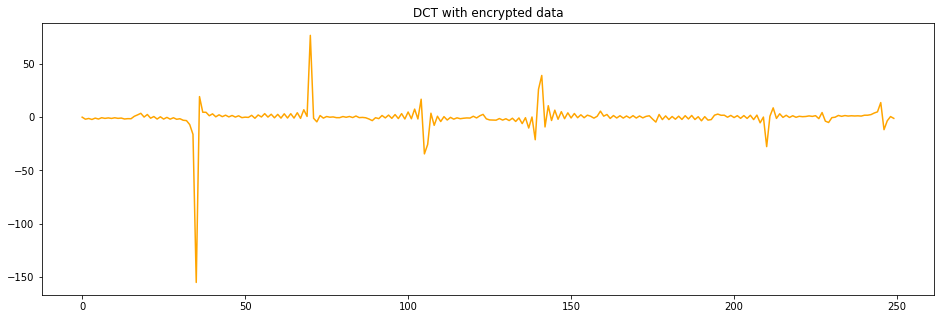

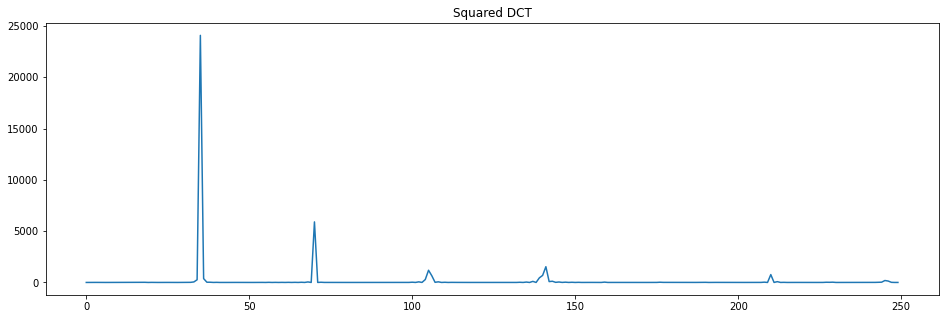

In [9]:
# compute DCT with encrypted data
f_bins = 250
N = len(input_data)

# construct DCT matrix
dctM = np.array([[math.cos(math.pi * f * (2 * i + 1) / (2 * N)) for f in range(f_bins)] for i in range(N)])
# matrix-vector multiplication
y = in_enc.mm(dctM)

dct_dec = np.array([x*2 for x in y.decrypt()])

plt.plot(dct_dec, color="orange")
plt.title("DCT with encrypted data")
plt.gcf().set_size_inches(16, 5)
plt.show()

plt.plot(dct_dec**2)
plt.title("Squared DCT")
plt.gcf().set_size_inches(16, 5)
plt.show()

dft2 = dft*dft

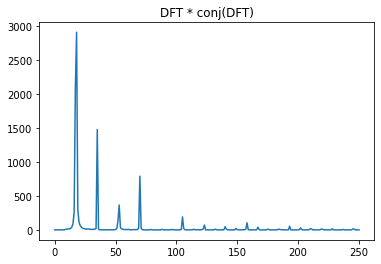

In [10]:
import cmath

dft2 = dft * np.conj(dft)
plt.plot(np.abs(dft2))
plt.title("DFT * conj(DFT)")
plt.show()

In [11]:
# Approximated Invert and Sqrt

# invert (0<=x<=2)
def inv(x,d):
    a = 2-x
    b = 1-x
    for n in range(d):
        b = b * b
        a = a * (1 + b)
    return a

# invert
def inv2(x,m,d):
    a = 2 - (2/m)*x
    b = 1 - (2/m)*x
    for i in range(d):
        b = b * b
        a = a * (1 + b)
    return (2/m) * a

# square root algorithm
def sqrt(x,d):
    a = x
    b = x - 1
    for n in range(d):
        a = a * (1 - b/2)
        b = b*b*((b-3)/4)
    return a

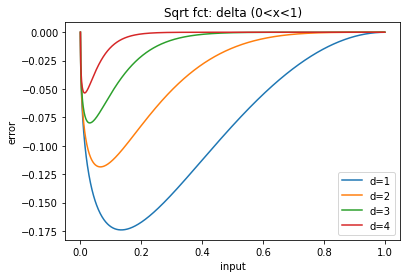

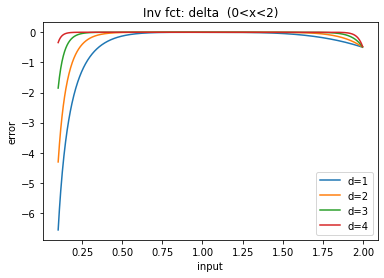

In [12]:
drange = range(1,5)

inpt = [x/1000 for x in range(1000)]
y = [np.sqrt(x/1000) for x in range(1000)]
for d in drange:
    x = [sqrt(x/1000,d) for x in range(1000)]
    
    diff = [a-b for a,b in zip(x,y)]
    plt.plot(inpt, diff, label=f'd={d}')

plt.title('Sqrt fct: delta (0<x<1)')
plt.xlabel("input")
plt.ylabel("error")
plt.legend()
plt.show()

inp = [x/500 for x in range(50,1000)]
y = [500/x for x in range(50,1000)]
for d in drange:
    x = [inv(x/500,d) for x in range(50,1000)]
    diff = [a-b for a,b in zip(x,y)]
    plt.plot(inp, diff, label=f'd={d}')
    
plt.title('Inv fct: delta  (0<x<2)')
plt.legend()
plt.xlabel("input")
plt.ylabel("error")
plt.show()

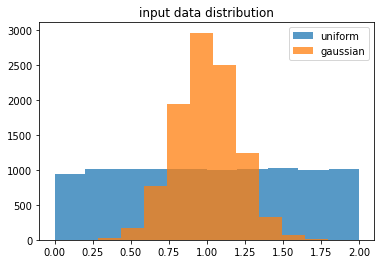

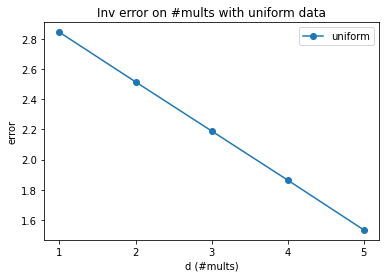

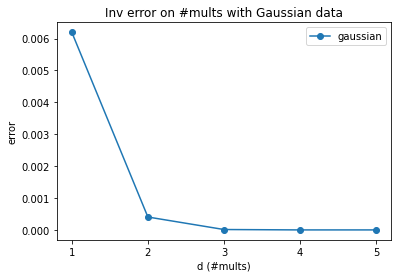

In [13]:
n = 10000
d = 5
d_range = list(range(d))
d_plt = list(range(1,d+1))

x_uni = [np.random.uniform(0,2) for _ in range(n)]
x_std = [np.random.normal(loc=1, scale=0.2) for _ in range(n)]

plt.hist(x_uni, label="uniform", alpha=0.75)
plt.hist(x_std, label="gaussian", alpha=0.75)
plt.legend()
plt.title("input data distribution")
plt.show()

deltas_uni = np.zeros(d)
deltas_std = np.zeros(d)

for _d in range(d):
    deltas_uni[_d] = sum([abs(inv(x,_d+1) - 1/x) for x in x_uni]) / n
    
    deltas_std[_d] = sum([abs(inv(x,_d+1) - 1/x) for x in x_std]) / n
    
plt.plot(d_plt, deltas_uni, "o-", label="uniform")
plt.legend()
plt.xlabel("d (#mults)")
plt.ylabel("error")
plt.title("Inv error on #mults with uniform data")
plt.xticks(np.arange(1, d+1, 1.0))
plt.show()
plt.plot(d_plt, deltas_std, "o-", label="gaussian")
plt.legend()
plt.xlabel("d (#mults)")
plt.ylabel("error")
plt.title("Inv error on #mults with Gaussian data")
plt.xticks(np.arange(1, d+1, 1.0))
plt.show()

In [14]:
# MaxIndex Algorithm
# input x: 0 <= x <= 1
def MaxIndex(data, l, t):
    y = [yi**(2**t) for yi in data]
    s = sum(y)
    sinv = inv2(s,sum(data),l)
    y = [yi*sinv for yi in y]
    
    return y

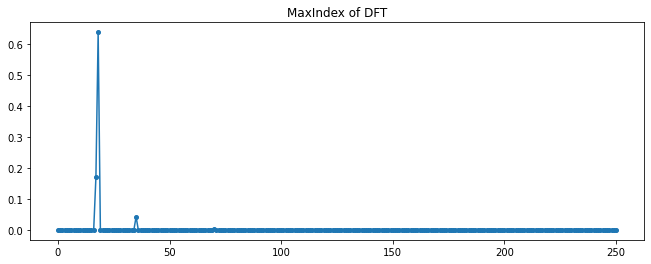

sum: 0.8530672529288323


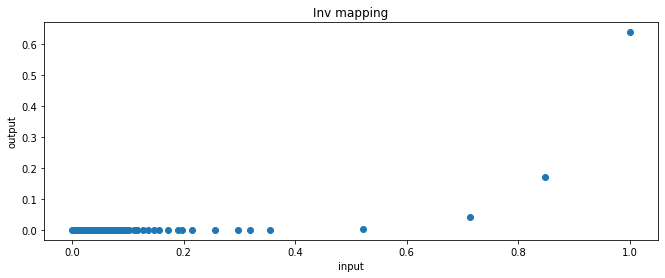

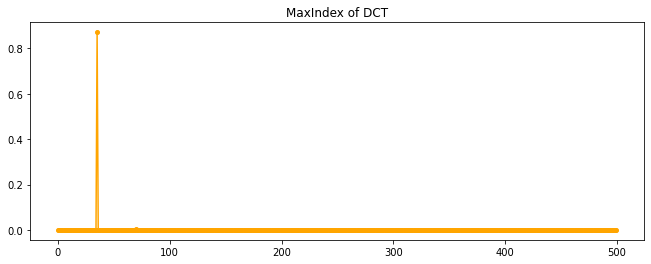

sum: 0.8737962578755383


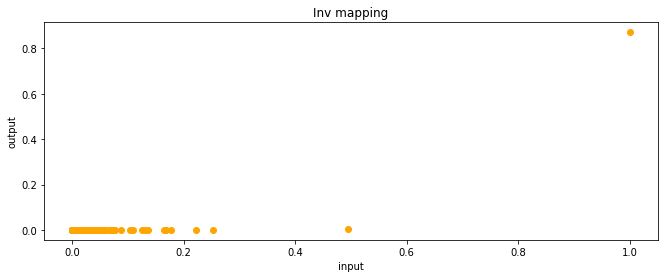

In [15]:
# DFT / DCT output used for Min/Max
plotWidth = 11

# preprocessing
data = np.abs(dft) / np.max(np.abs(dft))
# plot
maxIndexOut = MaxIndex(data,2,3)
plt.plot(maxIndexOut, "o-", markersize=4)
plt.gcf().set_size_inches(plotWidth, 4)
plt.title("MaxIndex of DFT")
plt.show()

print(f"sum: {sum(maxIndexOut)}")

plt.plot(data, maxIndexOut, "o")
plt.gcf().set_size_inches(plotWidth, 4)
plt.xlabel("input")
plt.ylabel("output")
plt.title("Inv mapping")
plt.show()

# preprocessing
data = np.abs(dct) / np.max(np.abs(dct))
# plot
maxIndexOut = MaxIndex(data,2,3)
plt.plot(maxIndexOut, "o-", markersize=4, color="orange")
plt.gcf().set_size_inches(plotWidth, 4)
plt.title("MaxIndex of DCT")
plt.show()

print(f"sum: {sum(maxIndexOut)}")

plt.plot(data, maxIndexOut, "o", color="orange")
plt.gcf().set_size_inches(plotWidth, 4)
plt.xlabel("input")
plt.ylabel("output")
plt.title("Inv mapping")
plt.show()